# This notebook provides comparing between various optimizers, here you can find theoretical and practical approach as well

In [1]:
# Classical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim

# Misc
import pdb
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
data = pd.read_csv('./data/MNIST/train.csv')
data = np.array(data)

In [4]:
len(data)

42000

In [5]:
max(data[0][1:])

255

In [3]:
class MNIST(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __getitem__(self, index):
        X = self.data[index][1:] #pixels
        y = self.data[index][0] #labels
        return torch.from_numpy(X).float()/255, torch.LongTensor(np.array([y])) #normalize X, y
    def __len__(self):
        return len(self.data)

In [4]:
mnist = MNIST(data)

In [5]:
len(mnist)

42000

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.l = nn.ModuleList(
        [nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        )
        #self.out = nn.Linear(layers[-1], classes) 
    def forward(self, x):
        for l in self.l:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=1)

In [7]:
data_dl = DataLoader(mnist,256, shuffle=True, num_workers=0)

In [8]:
it = iter(data_dl)

In [9]:
xs, ys = next(it) # batch_size(64) * number_of_pixels(784)

# Now let's talk a bit about negative log-likelihood loss function 

It is usually used in tandem with log softmax loss function which means:
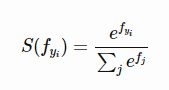

In sum S(f) gives us 1 for each example, which what we want, it is like probability, the label with the highest probability should be correct label. However, we need some confidence, so if we got a correct label for our example, but our probability is low, model is penalized by larger number. 
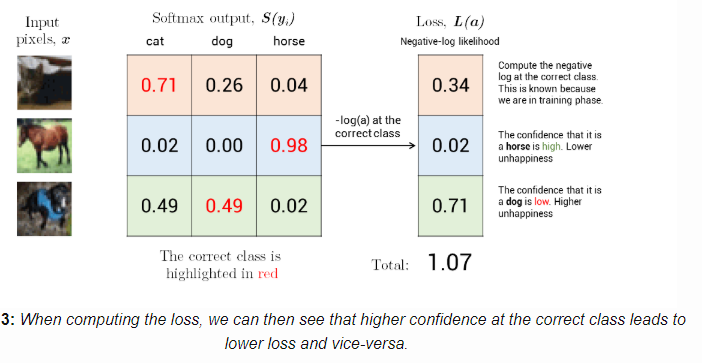

So let's look at first row, meaning first example. We have loss (0.26+0.04) = 0.3 and according to negative log-likelihood -log(0.71) = 0.14. to sum up loss equals to 0.3 + 0.14 = 0.44

In [10]:
epochs = 3
criterion = nn.NLLLoss()

# First, let's start with vanilla SGD(stochastic gradient descent) or mini-batch gradient descent

Stochastic gradient descent(online learning)take each example and calculate gradients to update parameters. So loss function can fluctuate a lot. SGD's fluctuation, on the one hand, enables it to jump to new and potentially better local minima. On the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting. However, it has been shown that when we slowly decrease the learning rate, SGD shows the same convergence behaviour as batch gradient descent, almost certainly converging to a local or the global minimum for non-convex and convex optimization respectively. 

Using mini-batches, it a) reduces the variance of the parameter updates, which can lead to more stable convergence; and b) can make use of highly optimized matrix optimizations common to state-of-the-art deep learning libraries that make computing the gradient w.r.t. a mini-batch very efficient. Common mini-batch sizes range between 50 and 256, but can vary for different applications

In [ ]:
#Architecture(not working code)
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in shuffled:
        grads = compute.grads(1, weight, loss_function)
        params -= lr*grads

In [11]:
layers = [784, 100,100,10]

# optimization init architecture

In [26]:
snet = SimpleNet(layers)

In [27]:
#wbs = list(snet.parameters()) #contain weights and biases of each layer

In [28]:
losses = [] #track of losses
lr = 1e-2 #learning rate

In [29]:
wbs = [(l.weight, l.bias) for l in snet.l]

In [30]:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for w, b in wbs:
            w.data -= lr*w.grad.data
            b.data -= lr*b.grad.data
            # zero the gradients
            w.grad.data.zero_()
            
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [31]:
sgd_losses_ = [(l.data.numpy()[0]) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses_]

In [32]:
len(sgd_losses_)

495

Text(0.5,1,'Vanilla SGD loss')

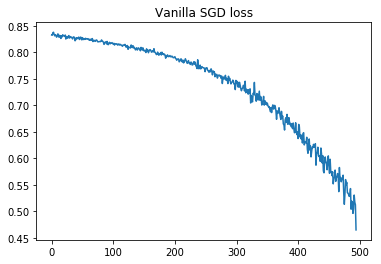

In [33]:
plt.plot(sgd_log_losses_)
plt.title("Vanilla SGD loss")

# Let's do the same but using PyTorch

In [78]:
snet = SimpleNet(layers)
criterion = nn.NLLLoss()
losses =[]
optimizer = [optim.SGD(lr=lr, params=snet.parameters()),optim.Adam(lr=lr, params=snet.parameters()),
                                                                  optim.RMSprop(lr=lr, params=snet.parameters())]

In [79]:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs) #go through model architecture our data X

        loss = criterion(outputs,labels.squeeze(dim = -1)) #calculate loss of true and predicted with NLLoss
        losses.append(loss) #tracking loss function
        loss.backward()#calculate gradients 

        optimizer[1].step() #update weights
        optimizer[1].zero_grad() #set gradients to zero

epoch 0
epoch 1
epoch 2


In [80]:
pytorch_losses_ = [loss.data.numpy()[0] for loss in losses]
pytorch_log_losses_ = [np.log(loss) for loss in pytorch_losses_]

Text(0.5,1,'Vanilla SGD PyTorch implementation')

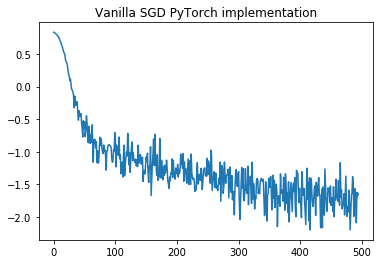

In [81]:
plt.plot(pytorch_log_losses_)
plt.title("Vanilla SGD PyTorch implementation")

# SGD with momentum

The difficulty arises in fact not from local minima but from saddle points, i.e. points where one dimension slopes up and another slopes down. These saddle points are usually surrounded by a plateau of the same error, which makes it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.

Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way. The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.

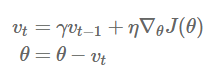

In [ ]:
#Algorithm
rho = 0.9
v_new = 0
for epoch in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get_batches(batch_size, shuffled):
        v_new = rho * v_prev + lr*computs.grad(shuffled, batch, weights)
        params = params - v_new
        v_prev = v_new

In [38]:
len(wbs)

3

In [39]:
snet = SimpleNet(layers)
losses = []
lr = 1e-3
rho = 0.9
wbs = [(l.weight, l.bias) for l in snet.l]

weights_v_prev = [0 for i in range(len(wbs))]
bias_v_prev = [0 for i in range(len(wbs))]


epochs = 3
for epoch in range(epochs):
    print(f"epoch: {epoch}")
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward() #calculate gradient
        
        for i,wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w_new = rho * weights_v_prev[i] + w.grad.data*lr
            b_new = rho*bias_v_prev[i] + b.grad.data*lr
            
            weights_v_prev[i] = w_new
            bias_v_prev[i] = b_new
            
            w.data -= w_new
            b.data -= b_new
            
            
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch: 0
epoch: 1
epoch: 2


In [40]:
sgdmom_losses_ = [(l.data.numpy()[0]) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

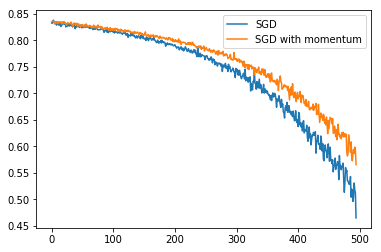

In [41]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.legend(("SGD", "SGD with momentum"))

# Nesterov

However, a ball that rolls down a hill, blindly following the slope, is highly unsatisfactory. We'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again.

Nesterov accelerated gradient (NAG) is a way to give our momentum term this kind of prescience. We know that we will use our momentum term $γ*v_{new}$ to move the parameters θ. Computing $θ−γ*v_{prev}$ thus gives us an approximation of the next position of the parameters (the gradient is missing for the full update), a rough idea where our parameters are going to be. We can now effectively look ahead by calculating the gradient not w.r.t. to our current parameters θ but w.r.t. the approximate future position of our parameters:

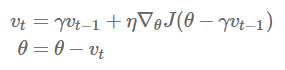

In [42]:
snet = SimpleNet(layers)
wbs = [(l.weight, l.bias) for l in snet.l]
rho =0.9
lr = 1e-3
losses = []
weight_prev = [0 for i in range(len(wbs))]
bias_prev = [0 for i in range(len(wbs))]

for epoch in range(epochs):
    print(f"epoch: {epoch}")
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        #update gradients
        for i, wb in enumerate(wbs):
            w = wb[0]
            
            w_original = w.data
            
            w_temp = rho*weight_prev[i]
            w.data -= w_temp
            outputs = snet(inputs) #calculate future outputs with w_temp
            
            loss = criterion(outputs, labels.squeeze(-1))
            loss.backward(retain_graph=True) #calculate gradients
            
            w_new = rho * weight_prev[i] + lr * w.grad.data 
            weight_prev[i] = w_new
            w.data = w_original
            w.data-=w_new # new weights
            
            #bias
            b = wb[1]
            b_original = b.data #save current state to use further
            
            b_temp = rho* bias_prev[i]
            b.data -= b_temp
            
            outputs = snet(inputs)#calculate future outputs with b_temp
            loss = criterion(outputs, labels.squeeze(-1))
            loss.backward(retain_graph=True)
            
            b_new = rho*bias_prev[i] + lr * b.grad.data
            bias_prev[i] = b_new
            b.data = b_original
            b.data-= b_new # new biases
            
            snet.zero_grad()#zero all gradients
        
    

epoch: 0
epoch: 1
epoch: 2


In [43]:
nesterov_losses_ = [(l.data.numpy()[0]) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]

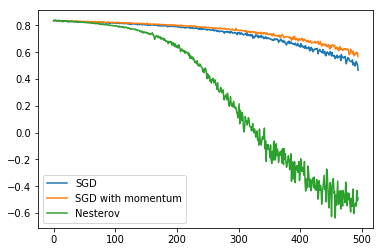

In [44]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.legend(("SGD", "SGD with momentum", "Nesterov"))

# Adagrad

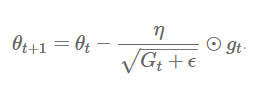

In [45]:
### init architecture
snet = SimpleNet(layers)

### get weight, bias objects
wbs = [(l.weight, l.bias) for l in snet.l]

### keep track of training loss
losses = []

###params
lr = 1e-3
grads_squared = [[torch.zeros(wb[0].size()), torch.zeros(wb[1].size())] for wb in wbs] #wights size, bias size for each layer
noise = 1e-8

epochs = 3

grads_squared[x][1] # where x is number of layer, [1] is index for bias, if [0] corresponds to weights 

In [46]:
### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w.data -= lr*w.grad.data / torch.sqrt(grads_squared[i][0] + noise)
            b.data -= lr*b.grad.data / torch.sqrt(grads_squared[i][1] + noise)
            
            grads_squared[i][0] += w.grad.data*w.grad.data
            grads_squared[i][1] += b.grad.data*b.grad.data
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [47]:
adagrad_losses_ = [(l.data.numpy()[0]) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

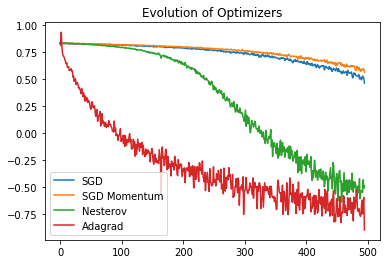

In [48]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad'))

# Adadelta/RMSProp

Adadelta [6] is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w.

Instead of inefficiently storing w previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients. The running average $E[g^2]_t$ at time step t then depends (as a fraction γ similarly to the Momentum term) only on the previous average and the current gradient:

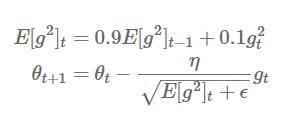

In [ ]:
#Algorithm
grads_squared = 0
for epoch in range(epochs):
    shuffled = random.shuffle(data)
    for batch in get_batches(shuffled, bs):
        grads = compute.grads(batch, weight, loss_function)
        grads_squared = 0.9 * grads_squared + 0.1* grads*grads
        parameter-=lr/(grads_squared+noise) * grads

In [57]:
snet = SimpleNet(layers)
wbs = [(l.weight, l.bias) for l in snet.l]

In [58]:
wbs[0]

(Parameter containing:
 -1.2074e-02  2.5524e-03 -2.0189e-02  ...  -1.5380e-02 -1.9480e-03 -1.2061e-02
 -2.4619e-02 -1.0778e-02  2.3030e-03  ...   3.1980e-02  2.4282e-02  7.2907e-03
 -2.9067e-02 -1.7982e-02  2.3345e-02  ...  -9.3739e-03 -8.4353e-03  1.5807e-03
                 ...                   ⋱                   ...                
 -2.2804e-02 -1.7651e-02 -1.4783e-02  ...  -3.5512e-02  8.5627e-03  2.1173e-02
  3.0074e-02 -2.5623e-02 -2.9339e-02  ...   3.1625e-03  1.5663e-02 -2.9712e-02
 -2.6668e-02  1.0856e-02  3.5419e-02  ...   1.8449e-02 -3.1805e-02  2.2896e-02
 [torch.FloatTensor of size 100x784], Parameter containing:
 1.00000e-02 *
   1.5794
   1.1408
  -2.5743
  -0.1883
  -1.0272
  -1.3951
   0.3424
   1.7152
  -0.9352
  -3.0121
   0.1678
  -3.5666
  -3.1225
  -2.7643
   1.3404
   1.9661
  -2.3106
   1.3586
  -3.3943
   1.9177
  -2.8418
  -3.4503
  -3.5483
   1.6231
  -2.9019
   0.4065
  -0.3759
  -2.7329
   3.2610
  -1.5610
  -1.3849
  -2.1504
   1.6829
   1.0807
   0.3899

In [59]:
lr =1e-3
epochs = 3
grads_squared = [[torch.zeros_like(wb[0]).data,  torch.zeros_like(wb[1]).data] for wb in wbs]

In [60]:
grads_squared[0]

[
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.FloatTensor of size 100x784], 
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
 [torch.FloatTensor of size 100]]

In [61]:
noise = 1e-8
losses = []
rho = 0.9

for epoch in range(epochs):
    print(f"epoch {epoch}")
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        #compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward() 
        
        #update weights
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            #algorithm 
            w.data -= lr*w.grad.data/(torch.sqrt(grads_squared[i][0] + noise))
            b.data -= lr*b.grad.data/(torch.sqrt(grads_squared[i][1] + noise))
            
            grads_squared[i][0] = rho * grads_squared[i][0] + (1-rho) * w.grad.data*w.grad.data
            grads_squared[i][1] = rho * grads_squared[i][1] + (1-rho) * b.grad.data*b.grad.data
            
            
            #zero gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [62]:
rmsprop_losses_ = [(l.data.numpy()[0]) for l in losses]
rmsprop_log_losses_ = [np.log(l) for l in rmsprop_losses_]

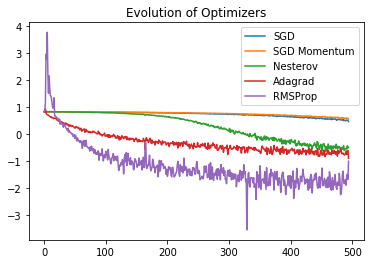

In [63]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp'))

# Adam

Adaptive Moment Estimation (Adam) [15] is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients mt, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface [29]. We compute the decaying averages of past and past squared gradients mt and vt respectively as follows:

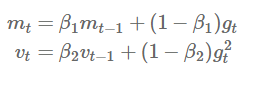

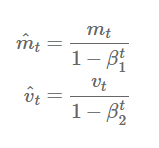

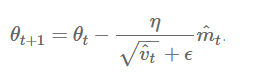

0.9 for $β_1$, 0.999 for $β_2$, and $10^{−8}$ for ϵ

In [ ]:
m = 0
v = 0
beta1 = 0.999
beta2 = 1e-8
t = 0

for i in range(epochs):
    t += 1
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch, weight - rho*v_prev, loss_func)
        m = beta1*m + (1 - beta1)*grads
        v = beta2*v + (1 - beta2)*grads*grads
        m_hat = m / (1 - beta1**t) # bias correction for first moment
        v_hat = v / (1 - beta1**t) # bias correction for second moment
        params -= lr*m_hat/(np.sqrt(v_hat) + noise)

In [71]:
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(l.weight, l.bias) for l in snet.l]

### keep track of training loss
losses = []

### params
lr = 1e-3

### [((m, v), (m, v))] weight and bias m v prevs
m_v_prevs = [[[torch.zeros_like(wb[0]).data, torch.zeros_like(wb[0]).data], [torch.zeros_like(wb[1]).data, torch.zeros_like(wb[1]).data]]  for wb in wbs]

noise = 1e-8
beta1 = 0.9
beta2 = 0.999

epochs = 3

t = 0

In [72]:
for epoch in range(epochs):
    print(f"epoch {epoch}")
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        t+=1
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward() #gradients compute
        
        #update parameters using algorithm
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w_mv_t_prev = m_v_prevs[i][0]
            w_m_t_prev = w_mv_t_prev[0] # m for weights
            w_v_t_prev = w_mv_t_prev[1] #v for weights
            
            m_t = beta1* w_m_t_prev + (1-beta1)* w.grad.data
            v_t = beta2* w_v_t_prev + (1-beta2)*w.grad.data*w.grad.data
            
            m_v_prevs[i][0][0] = m_t
            m_v_prevs[i][0][1] = v_t
            #hat
            m_t_hat = m_t/(1 - beta1**t)
            v_t_hat = v_t/(1-beta2**t)
            
            w.data-=lr*m_t_hat/(torch.sqrt(v_t_hat + noise))
            
            #bias
            
            b_mv_t_prev = m_v_prevs[i][1]
            b_m_t_prev = b_mv_t_prev[0] # m for weights
            b_v_t_prev = b_mv_t_prev[1] #v for weights
            
            m_t = beta1* b_m_t_prev + (1-beta1)* b.grad.data
            v_t = beta2* b_v_t_prev + (1-beta2)*b.grad.data*b.grad.data
            
            m_v_prevs[i][1][0] = m_t
            m_v_prevs[i][1][1] = v_t
            
            #hat
            m_t_hat = m_t/(1 - beta1**t)
            v_t_hat = v_t/(1-beta2**t)
            
            b.data-=lr*m_t_hat/(torch.sqrt(v_t_hat + noise))
            
            #zero gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        
        
        

epoch 0
epoch 1
epoch 2


In [73]:
adam_losses_ = [(l.data.numpy()[0]) for l in losses]
adam_log_losses_ = [np.log(l) for l in adam_losses_]

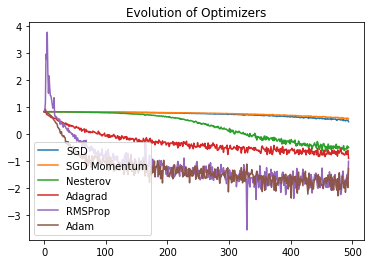

In [74]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam'))